In [45]:
import numpy as np
import pandas as pd
import os

import re
from ast import literal_eval
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 33M Feb 13 11:48 data/Byvsij_SSSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 75M Feb 13 11:35 data/Ekonomika.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 51M Feb 13 11:45 data/Mir.csv.bz2


In [47]:
name_dataset = 'Mir'

### load data

In [48]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(82154, 6)
CPU times: user 17.7 s, sys: 2.01 s, total: 19.7 s
Wall time: 16.4 s


In [49]:
df.head()

,date,topic,text,predict,text_new,lemmatized_text
0,2008-02-11 10:51:00,"""В России""",- Добивающийся выдвижения кандидатом в презид...,Мир,добивающийся выдвижения кандидатом в президент...,"['добиваться', 'выдвижение', 'кандидат', 'сша'..."
1,2008-02-11 12:15:00,"""В России""",- Министр обороны США Роберт Гейтс заявил что...,Мир,министр обороны сша роберт_гейтс заявил что мо...,"['министр', 'оборона', 'сша', 'роберт_гейтс', ..."
2,2008-02-11 12:46:00,"""В России""",- В США продолжается сезон предварительных вы...,Мир,в сша продолжается сезон предварительных выбор...,"['сша', 'продолжаться', 'сезон', 'предваритель..."
3,2008-02-11 13:16:00,"""В России""","""Американский военнослужащий 38 лет задержан в...",Мир,американский военнослужащий лет задержан в яп...,"['американский', 'военнослужащий', 'задержать'..."
4,2008-02-11 16:14:00,"""В России""",- Сербия в случае признания некоторыми страна...,Мир,сербия в случае признания некоторыми странами ...,"['сербия', 'случай', 'признание', 'некоторый',..."


* parse data

In [50]:
df['year'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.head()

,date,topic,text,predict,text_new,lemmatized_text,year,month
0,2008-02-11 10:51:00,"""В России""",- Добивающийся выдвижения кандидатом в презид...,Мир,добивающийся выдвижения кандидатом в президент...,"['добиваться', 'выдвижение', 'кандидат', 'сша'...",2008,2
1,2008-02-11 12:15:00,"""В России""",- Министр обороны США Роберт Гейтс заявил что...,Мир,министр обороны сша роберт_гейтс заявил что мо...,"['министр', 'оборона', 'сша', 'роберт_гейтс', ...",2008,2
2,2008-02-11 12:46:00,"""В России""",- В США продолжается сезон предварительных вы...,Мир,в сша продолжается сезон предварительных выбор...,"['сша', 'продолжаться', 'сезон', 'предваритель...",2008,2
3,2008-02-11 13:16:00,"""В России""","""Американский военнослужащий 38 лет задержан в...",Мир,американский военнослужащий лет задержан в яп...,"['американский', 'военнослужащий', 'задержать'...",2008,2
4,2008-02-11 16:14:00,"""В России""",- Сербия в случае признания некоторыми страна...,Мир,сербия в случае признания некоторыми странами ...,"['сербия', 'случай', 'признание', 'некоторый',...",2008,2


In [51]:
df.year.value_counts()

2017    10185
2016    10074
2018     9056
2013     8640
2015     8494
2014     7378
2009     6583
2012     6198
2008     5360
2011     5181
2010     4626
2019      379
Name: year, dtype: int64

In [52]:
df.month.value_counts()

3     7770
10    7351
4     7294
11    7148
7     6827
9     6741
8     6686
12    6581
1     6535
5     6518
6     6423
2     6280
Name: month, dtype: int64

In [53]:
df.lemmatized_text = df.lemmatized_text.apply(lambda x: literal_eval(x))

### preprocess if text with lemma

* add docID

In [54]:
df['docID'] = list(range(df.shape[0]))

In [55]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[добиваться, выдвижение, кандидат, сша, демокр..."
1,1,2008,2,"[министр, оборона, сша, роберт_гейтс, моджахед..."


In [56]:
print(df.shape)
df.isnull().sum()

(82154, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [57]:
df.year.min(),df.year.max()

(2008, 2019)

### preprocess if text full

* get dates

In [58]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

<unknown>:2: DeprecationWarning: invalid escape sequence \d


KeyError: 'url'

* clean text

In [59]:
import preprocessing_tools as pr

In [60]:
%%time
df.text = df.text.apply(pr.clean_text)

AttributeError: 'DataFrame' object has no attribute 'text'

In [61]:
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[добиваться, выдвижение, кандидат, сша, демокр..."
1,1,2008,2,"[министр, оборона, сша, роберт_гейтс, моджахед..."


* cleanedNames

In [62]:
from cleanedNames import KeyProc
cn = KeyProc()

In [63]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

AttributeError: 'DataFrame' object has no attribute 'text'

* lemmatization

In [64]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

AttributeError: 'DataFrame' object has no attribute 'text'

* add docID

In [65]:
df['docID'] = list(range(df.shape[0]))

In [66]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[добиваться, выдвижение, кандидат, сша, демокр..."
1,1,2008,2,"[министр, оборона, сша, роберт_гейтс, моджахед..."


In [67]:
print(df.shape)
df.isnull().sum()

(82154, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [68]:
df.year.min()

2008

## model

* prepare

In [69]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 660 ms, sys: 173 ms, total: 833 ms
Wall time: 691 ms


In [70]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [71]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/Mir", num_batches=84)
CPU times: user 22.6 s, sys: 388 ms, total: 23 s
Wall time: 4.27 s


In [72]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [73]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=a00e1303-75e2-4da2-9668-3e4d7c81dbb9, num_entries=23076)

In [74]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [76]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 10
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

#topic 10.........
	SparsityThetaScore: 0.5814064741134644
	SparsityPhiScore: 0.776404082775116
	PerplexityScore: 2532.59228515625
	time: 0:01:11.101117
#topic 11.........
	SparsityThetaScore: 0.6023103594779968
	SparsityPhiScore: 0.7958288192749023
	PerplexityScore: 2466.590087890625
	time: 0:01:13.331197
#topic 12.........
	SparsityThetaScore: 0.6175426840782166
	SparsityPhiScore: 0.8092607259750366
	PerplexityScore: 2399.0205078125
	time: 0:01:13.895690
#topic 13.........
	SparsityThetaScore: 0.6299335360527039
	SparsityPhiScore: 0.822192907333374
	PerplexityScore: 2339.880859375
	time: 0:01:16.042878
#topic 14.........
	SparsityThetaScore: 0.6464157700538635
	SparsityPhiScore: 0.8306992053985596
	PerplexityScore: 2310.80029296875
	time: 0:01:21.125392
#topic 15.........
	SparsityThetaScore: 0.653684139251709
	SparsityPhiScore: 0.8401253819465637
	PerplexityScore: 2252.946044921875
	time: 0:01:22.136982
#topic 16.........
	SparsityThetaScore: 0.6638557314872742
	SparsityPhiScore: 0.

In [ ]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

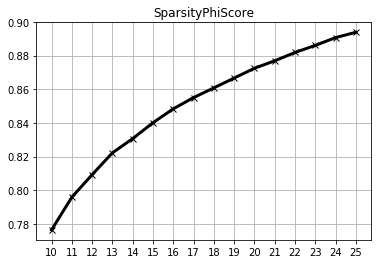

In [77]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [78]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.7, 0.8]

In [79]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.7: 2, 0.8: 14}

Text(0.5, 1.0, 'SparsityThetaScore')

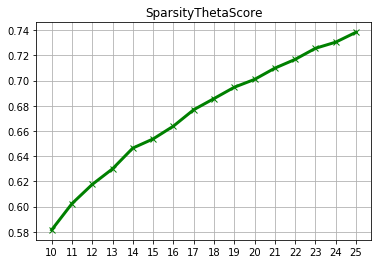

In [80]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [81]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.5, 0.6, 0.7]

In [82]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.5: 1, 0.6: 9, 0.7: 6}

Text(0.5, 1.0, 'PerplexityScore')

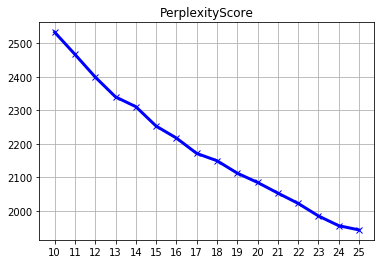

In [83]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [84]:
perplexity

[2532.59228515625,
 2466.590087890625,
 2399.0205078125,
 2339.880859375,
 2310.80029296875,
 2252.946044921875,
 2217.364013671875,
 2171.51611328125,
 2149.740234375,
 2112.75244140625,
 2085.051025390625,
 2053.30078125,
 2022.6058349609375,
 1985.1593017578125,
 1956.2056884765625,
 1943.6248779296875]

### select the best model

In [85]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.7: 2, 0.8: 14}
d_stheta: {0.5: 1, 0.6: 9, 0.7: 6}


In [86]:
select_topics = 25 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

25


---

In [ ]:
'''
select_topics = 17

num_topics = select_topics
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')

best_model = model.clone()
print(f'best_model.num_topics:{best_model.num_topics}')
'''

---

### print top words for each topics

In [87]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['япония' 'судно' 'японский' 'остров' 'судный' 'вода' 'экипаж' 'аэс'
 'моряк' 'морской']
topic_1: ['партия' 'выбор' 'трамп' 'пост' 'кандидат' 'парламент' 'дональд_трамп'
 'президентский' 'голос' 'выборы']
topic_2: ['украина' 'германия' 'великобритания' 'ес' 'граница' 'беженец' 'мигрант'
 'европа' 'греция' 'европейский']
topic_3: ['самолёт' 'корабль' 'полёт' 'база' 'воздушный' 'ввс' 'вмс' 'учение'
 'граница' 'авиабаза']
topic_4: ['миллион' 'миллиард' 'евро' 'финансовый' 'экономический' 'помощь'
 'экономика' 'избиратель' 'сумма' 'проект']
topic_5: ['корея' 'кндр' 'южный' 'ракета' 'северный' 'ядерный' 'пхеньян'
 'северокорейский' 'южнокорейский' 'испытание']
topic_6: ['подчеркнуть' 'хотеть' 'иф' 'добавить' 'очень' 'проблема' 'интервью'
 'мнение' 'сделать' 'большой']
topic_7: ['саудовский' 'расследование' 'аравия' 'сотрудник' 'документ' 'издание'
 'разведка' 'спецслужба' 'источник' 'письмо']
topic_8: ['оон' 'совет' 'резолюция' 'сб' 'заседание' 'проект' 'миссия' 'мид'
 'право' 'кон

### get topics-docs matrix

shape theta: (25, 82475)


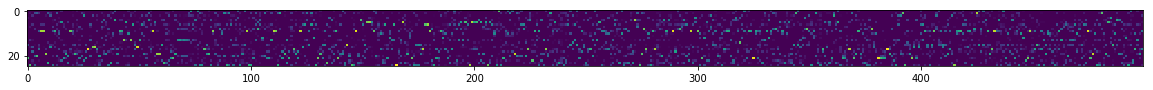

In [88]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [89]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
38000,0.00000,0.0,0.070142,0.0,0.081003,0.024586,0.316623,0.00000,0.124417,0.000000,...,0.000000,0.0,0.0,0.0,0.179453,0.000000,0.000000,0.000000,0.148304,0.000000
38001,0.02861,0.0,0.000000,0.0,0.000000,0.000000,0.025654,0.00000,0.167724,0.101092,...,0.311974,0.0,0.0,0.0,0.000000,0.000000,0.015308,0.187849,0.000000,0.098716
38002,0.00000,0.0,0.405746,0.0,0.000000,0.026067,0.000000,0.00000,0.000000,0.048573,...,0.000000,0.0,0.0,0.0,0.191881,0.000000,0.000000,0.297815,0.029918,0.000000
38003,0.00000,0.0,0.218846,0.0,0.000000,0.000000,0.034491,0.12815,0.147215,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.047858,0.000000,0.000000,0.329964,0.000000
38004,0.00000,0.0,0.060939,0.0,0.000000,0.000000,0.386245,0.00000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.420238,0.000000


## DataViz

In [90]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,0,2008,2,0.000000,0.686717,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.313283,0.0,0.000000
1,1,2008,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.302443,...,0.000000,0.019523,0.173319,0.0,0.0,0.087664,0.0,0.000000,0.0,0.000000
2,2,2008,2,0.000000,0.582118,0.004265,0.000000,0.029992,0.0,0.168410,...,0.004936,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.161143,0.0,0.000000
3,3,2008,2,0.098506,0.021152,0.000000,0.028094,0.000000,0.0,0.155990,...,0.185147,0.000000,0.062395,0.0,0.0,0.000000,0.0,0.000000,0.0,0.186823
4,4,2008,2,0.000000,0.118601,0.225262,0.000000,0.000000,0.0,0.263451,...,0.000000,0.018281,0.000000,0.0,0.0,0.038183,0.0,0.000000,0.0,0.024796


In [91]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (132, 25)


topic_0    topic_1    topic_2   topic_3    topic_4    topic_5  \
year month                                                                    
2008 2       4.773681  13.954649  10.600931  2.916529   3.581778   3.210496   
     3      12.852572  35.055714  17.519463  7.226132  18.765320   6.885447   
     4      13.605276  25.489235  16.198780  4.140768  19.329884  11.877307   
     5      17.194830  26.061014  11.748179  8.137860  20.108368   7.502437   
     6      14.187271  21.516674  10.894103  5.190045  19.053900   4.554274   

              topic_6    topic_7    topic_8    topic_9    ...       topic_15  \
year month                                                ...                  
2008 2      16.182819   2.652663  25.305307  19.098888    ...      11.376100   
     3      36.125973  10.676852  27.161451  34.029861    ...      15.985574   
     4      31.624969   8.598269  22.420773  29.477213    ...      21.110163   
     5      26.676004   8.409225  15.070693  39.048012    ...      13.434444   
     6      20.742842   4.778524  14.229921  34.598621    ...      13.214319   

             topic_16   topic_17   topic_18   topic_19   topic_20   topic_21  \
year month                                                                     
2008 2       6.112424   7.559244   3.510258   2.757029   5.497858   2.834278   
     3      14.408620  12.480580  11.246682  10.263052  11.924249   6.488498   
     4      14.493300  16.477776  10.686760  17.753368  16.395071   9.198570   
     5       9.222532  71.919991  12.582729  11.514003  15.065102   8.742979   
     6       9.348993  37.238907   9.746492   7.413908  10.426337  11.205447   

             topic_22   topic_23   topic_24  
year month                                   
2008 2       7.891479   6.456928  14.196599  
     3      13.547550  23.137518  24.651289  
     4      19.668577  24.534334  19.217213  
     5      22.004070  28.962589  16.703232  
     6      15.092990  15.486993  12.287542  

[5 rows x 25 columns]

### straightforward matrix heatmap

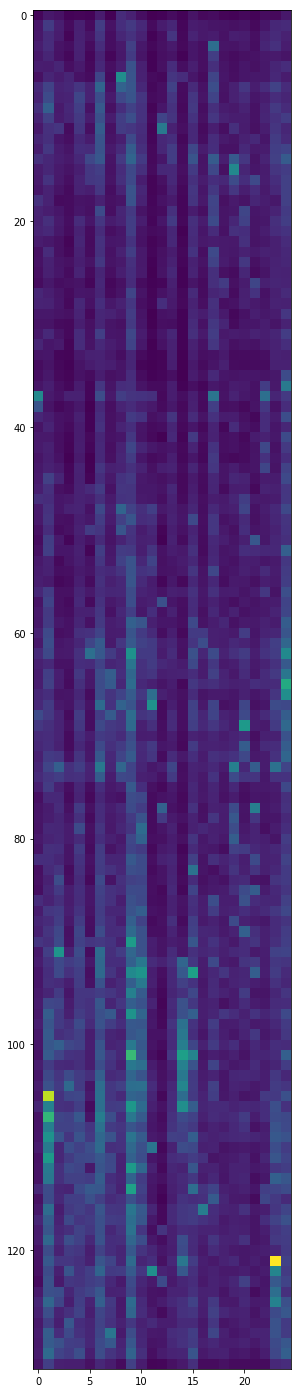

In [92]:
plt.figure(figsize=(5, 25))
plt.imshow(gb[topics])

## pygal

In [93]:
import pygal
from IPython.display import SVG, HTML

html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [94]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [95]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [96]:
import joypy # !pip install joypy

In [97]:
print(joined.shape)
joined.head()

(82154, 28)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,0,2008,2,0.000000,0.686717,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.313283,0.0,0.000000
1,1,2008,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.302443,...,0.000000,0.019523,0.173319,0.0,0.0,0.087664,0.0,0.000000,0.0,0.000000
2,2,2008,2,0.000000,0.582118,0.004265,0.000000,0.029992,0.0,0.168410,...,0.004936,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.161143,0.0,0.000000
3,3,2008,2,0.098506,0.021152,0.000000,0.028094,0.000000,0.0,0.155990,...,0.185147,0.000000,0.062395,0.0,0.0,0.000000,0.0,0.000000,0.0,0.186823
4,4,2008,2,0.000000,0.118601,0.225262,0.000000,0.000000,0.0,0.263451,...,0.000000,0.018281,0.000000,0.0,0.0,0.038183,0.0,0.000000,0.0,0.024796


In [98]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,date
0,0,2008,2,0.000000,0.686717,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.313283,0.0,0.000000,2008-02-01
1,1,2008,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.302443,...,0.019523,0.173319,0.0,0.0,0.087664,0.0,0.000000,0.0,0.000000,2008-02-01
2,2,2008,2,0.000000,0.582118,0.004265,0.000000,0.029992,0.0,0.168410,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.161143,0.0,0.000000,2008-02-01
3,3,2008,2,0.098506,0.021152,0.000000,0.028094,0.000000,0.0,0.155990,...,0.000000,0.062395,0.0,0.0,0.000000,0.0,0.000000,0.0,0.186823,2008-02-01
4,4,2008,2,0.000000,0.118601,0.225262,0.000000,0.000000,0.0,0.263451,...,0.018281,0.000000,0.0,0.0,0.038183,0.0,0.000000,0.0,0.024796,2008-02-01


In [99]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd2 = dd.groupby(['date','topic']).sum()

dd2=dd2.reset_index()

dd.head()

,date,topic,mentions
3,2008-02-01,topic_0,0.098506
6,2008-02-01,topic_0,0.039220
7,2008-02-01,topic_0,0.150432
9,2008-02-01,topic_0,0.018022
18,2008-02-01,topic_0,0.035429


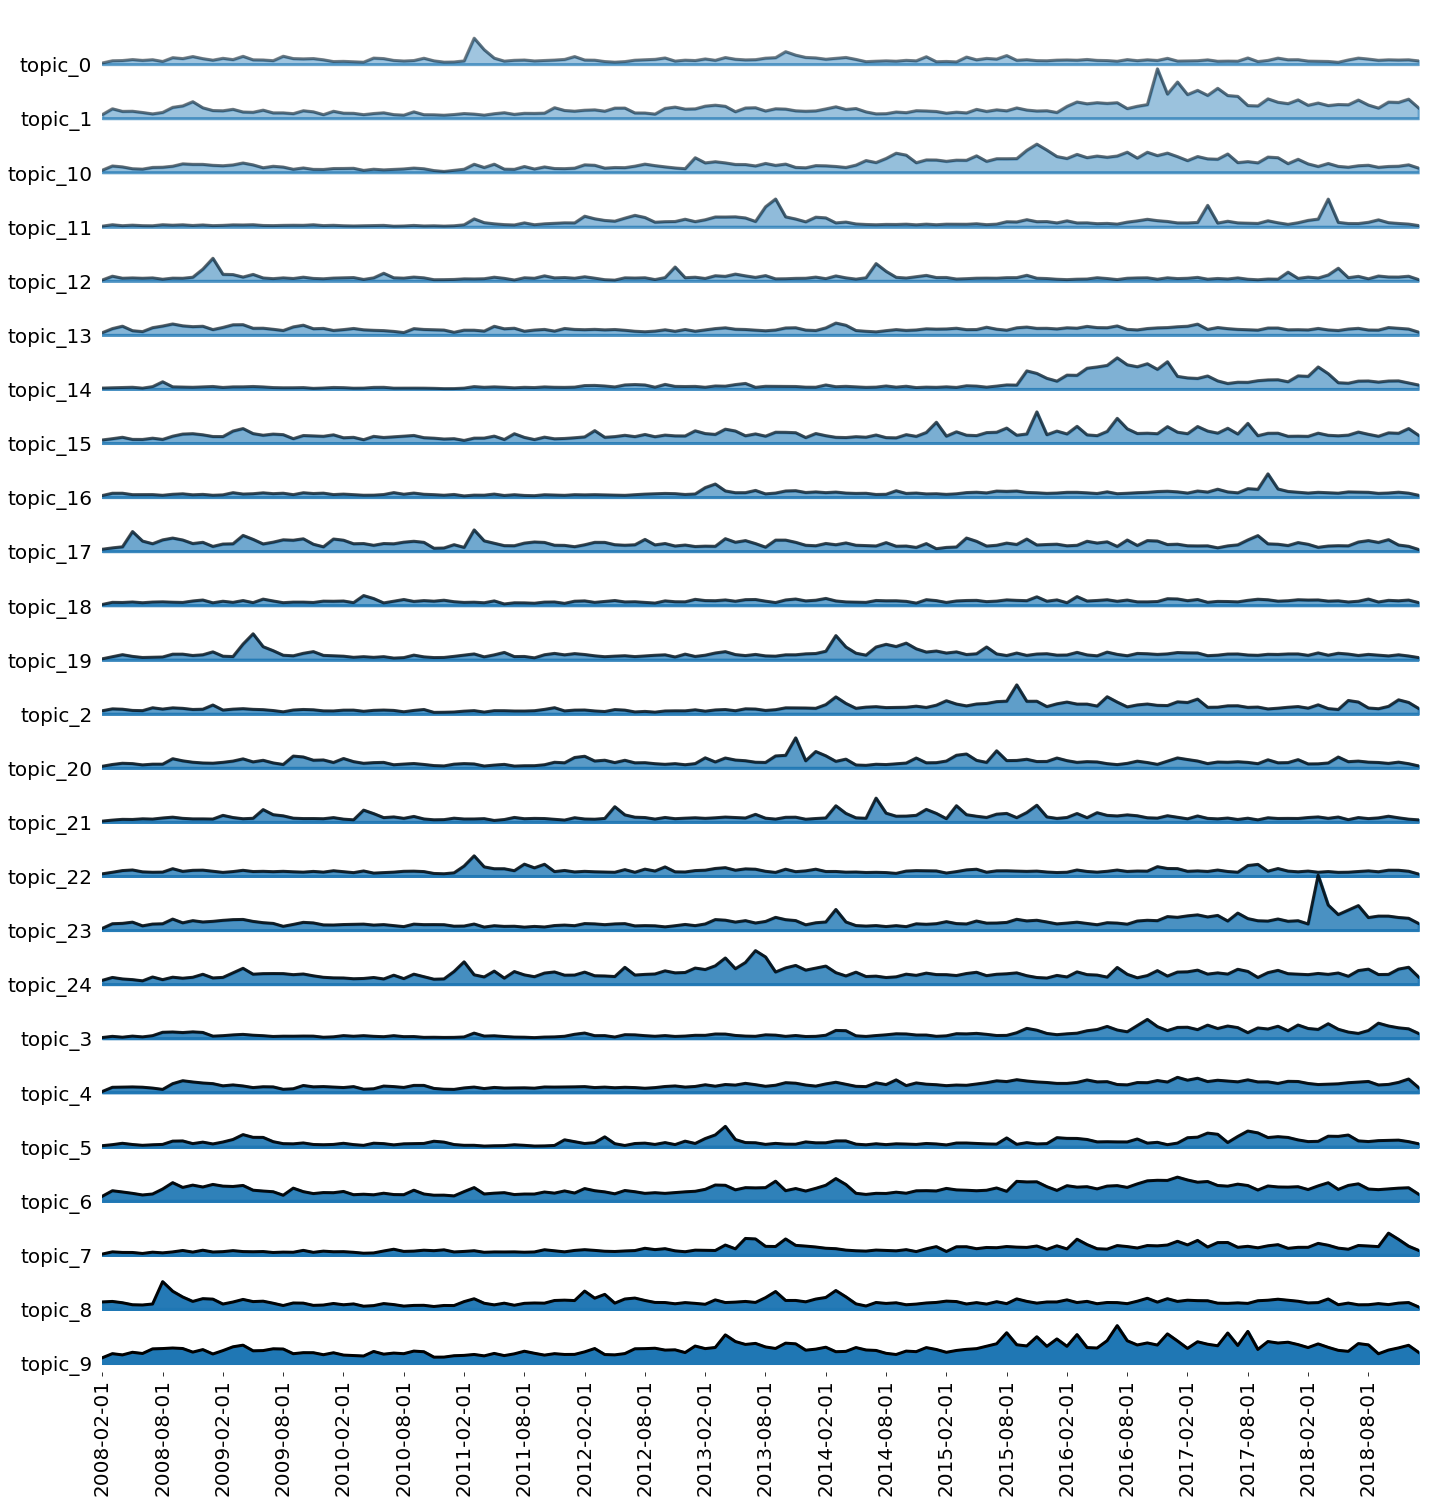

In [100]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [101]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")